<a href="https://colab.research.google.com/github/classjr/DevelopmentAndroid/blob/master/projectVisionComputer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

# Se você estiver acessando a pasta 'TCC01' e não foi quem a criou, terá que vincular ao
# seu drive local apenas clicando em cima da pasta citada com o botão direito
# e escolha a opção 'Adicionar Atalho ao google Drive' para criar um link e assim
# funcionar normalmente o acesso.
%cd drive/MyDrive/TCC01
%ls .



In [ ]:
#Só execute esse comando caso não tenha os arquivos de teste e treino no drive
!curl -L "https://app.roboflow.com/ds/mse5jwKG5x?key=r9ZYOsD08R" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [152]:
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np


NUMERO_EPOCA = 20
TAXA_APRENDIZADO = 0.0001
TAMANHO_IMAGEM = 224
TAMANHO_BATCH = 20
PORCENTAGEM_TEST = 0.20


In [153]:
import pandas as pd
import os
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from sklearn.model_selection import train_test_split

class FileCsv:

    def read(self,path):
        try:
            images = {}
            data = pd.read_csv(path)
            for index in range(len(data)):
                #print(data.loc[index][0])
                if data.loc[index][0] not in images:
                    annot = []
                else:
                    annot = images[ data.loc[index][0] ]
                annot.append([data.loc[index][4],data.loc[index][5],data.loc[index][6],data.loc[index][7]])
                images[data.loc[index][0]] = annot
            return images
        except ValueError as error:
            print(error)

class Image:

  def processing(self, img, sigma=0.33):
    try:
      # Converte imagem para cinza
      gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
      thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,39,1)
      #cv2_imshow( thresh )
      medianValues = np.median(thresh)
      lower = int(max(0, (1.0 - sigma) * medianValues))
      upper = int(min(255, (1.0 + sigma) * medianValues))
      edged = cv2.Canny(thresh, lower, upper)

      #cv2_imshow( edged )
      self.getLetters(img, thresh)
      self.getLetters(img, edged)
  
    except ValueError as error:
      print(error)

  def getLetters(self, img, edges):
    try:
      ctrs, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
      img_area = img.shape[0]*img.shape[1]
      for i, ctr in enumerate(sorted_ctrs):
        x, y, w, h = cv2.boundingRect(ctr)
        #cv2.rectangle(img,(x,y),( x + w, y + h ),(0,0,255),1)
        roi_area = w*h
        roi_ratio = roi_area/img_area
        if((roi_ratio >= 0.015) and (roi_ratio < 0.09)):
          if ((h>1.8*w) and (4*w>=h)):
            cv2.rectangle(img,(x,y),( x + w, y + h ),(0,0,255),1)
      cv2_imshow( img )

    except ValueError as error:
      print(error)


class LoadImage:

  def getRoi(self, img, points):
    try:
      image = img[int(points[1]):int(points[3]), int(points[0]):int(points[2])] #Retorna uma subimagem
      #image = cv2.resize(image, (150,75), interpolation= cv2.INTER_LINEAR)
      return image
    except ValueError as error:
      print(error)

  def drawPlate(self,img, points, color=(0,255,0) ):
    try:
      image = cv2.rectangle(img, (points[0],points[1]), (points[2],points[3]), color , 1) #BGR
      return image
    except ValueError as error:
      print(error)

  def loading(self, dicionario):
    try:
      imgs   = []
      points = []
      for pathImg in dicionario.keys():  # Pois keys são os nomes das imagens
        img = (cv2.imread(os.path.join('train', pathImg) ))
        point = dicionario.get(pathImg)[0]# Pega as anotações da placa [x, y, x+w, y+h]
        (H,W) = img.shape[:2]             # Pega o tamanho da imagem em questão
        point[0] = float(point[0]/W)
        point[1] = float(point[1]/H)
        point[2] = float(point[2]/W)
        point[3] = float(point[3]/H)
        points.append( np.array(point, dtype="float32") )
        img = cv2.resize(img, (TAMANHO_IMAGEM,TAMANHO_IMAGEM), interpolation= cv2.INTER_LINEAR)
        imgs.append( np.array(img, dtype="float32") /255.0 )
      return np.asarray(imgs), np.asarray(points)
    except ValueError as error:
      print(error)

csv = FileCsv()
dicionarioImagens = csv.read('train/_annotations.csv')
ld = LoadImage()
x, y = ld.loading(dicionarioImagens)

# Realiza a divisão de dataset em 90 e 10%, ou seja, 90% das imagens
# para treino e 10% para teste durante o treinamento
xtrain, xtest, ytrain, ytest=train_test_split(x, y, test_size=PORCENTAGEM_TEST)
print('*'*20 , 'Carregou as imagens ', '*'*20) 


******************** Carregou as imagens  ********************


In [155]:
# Referencia para estudo: https://pyimagesearch.com/2020/10/05/object-detection-bounding-box-regression-with-keras-tensorflow-and-deep-learning/
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model


class Modelos:

  def manual(self):
    try:
      # Rede criada manualmente, através da configuração de novas camadas
      model = keras.Sequential()
      model.add(keras.layers.Conv2D(32, 2, activation="relu", input_shape=(TAMANHO_IMAGEM, TAMANHO_IMAGEM,3)))
      model.add(keras.layers.Flatten())
      model.add(keras.layers.Dense(64, activation="relu"))
      model.add(keras.layers.Dense(4, activation="sigmoid"))
      
      model.compile(loss="mse", optimizer="adam")
      return model, 'manual'
    except ValueError as error:
      print(error)
  #Exemplos de outras redes: InceptionV3,mobileNet, efficientNet e etc 
  def transfer_learning_vgg(self):
    try:

      model = VGG16(weights="imagenet", include_top=False,
	    input_tensor=Input(shape=(TAMANHO_IMAGEM, TAMANHO_IMAGEM, 3)))
      model.trainable = False
      saidaVGG = model.output
      flatten = Flatten()(saidaVGG)

      bboxHead = Dense(128, activation="relu")(flatten)
      bboxHead = Dense(64, activation="relu")(bboxHead)
      bboxHead = Dense(32, activation="relu")(bboxHead)
      bboxHead = Dense(4, activation="sigmoid")(bboxHead)
      model = Model(inputs=model.input, outputs=bboxHead)
      return model, 'vgg16'
    except ValueError as error:
      print(error)

teste = Modelos()
#model, name = teste.manual()
model, name = teste.transfer_learning_vgg()

print('*'*20 , 'Criou o modelo de rede ', '*'*20) 


******************** Criou o modelo de rede  ********************


Epoch 1/20
2/2 [==============================] - 25s 14s/step - loss: 0.0675 - accuracy: 0.1111 - val_loss: 0.0112 - val_accuracy: 0.7778
Epoch 2/20
2/2 [==============================] - 21s 12s/step - loss: 0.0149 - accuracy: 0.9167 - val_loss: 0.0094 - val_accuracy: 0.7778
Epoch 3/20
2/2 [==============================] - 21s 11s/step - loss: 0.0160 - accuracy: 0.8889 - val_loss: 0.0089 - val_accuracy: 0.7778
Epoch 4/20
2/2 [==============================] - 21s 11s/step - loss: 0.0137 - accuracy: 0.8889 - val_loss: 0.0074 - val_accuracy: 0.7778
Epoch 5/20
2/2 [==============================] - 20s 11s/step - loss: 0.0094 - accuracy: 0.8889 - val_loss: 0.0075 - val_accuracy: 0.7778
Epoch 6/20
2/2 [==============================] - 22s 12s/step - loss: 0.0076 - accuracy: 0.8889 - val_loss: 0.0094 - val_accuracy: 0.7778
Epoch 7/20
2/2 [==============================] - 21s 11s/step - loss: 0.0075 - accuracy: 0.8889 - val_loss: 0.0097 - val_accuracy: 0.7778
Epoch 8/20
2/2 [===========

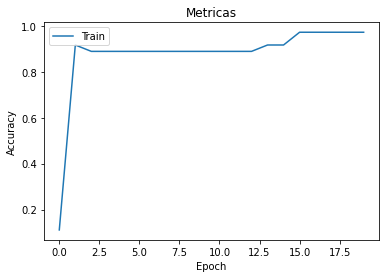

1/1 [==============================] - 4s 4s/step - loss: 0.0035 - accuracy: 0.8889


In [156]:
from datetime import datetime
hour  = datetime.now()

opt = keras.optimizers.Adam(learning_rate=TAXA_APRENDIZADO)
# Técnica capaz de parar o treinamento caso não exista uma melhora durante 5 épocas
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

#model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy',tensorflow.keras.metrics.Precision(), tensorflow.keras.metrics.Recall()])
model.compile(optimizer=opt,loss='mse',metrics=['accuracy',])

# Realiza o treinamento
historico = model.fit(xtrain, ytrain,validation_data=(xtest,ytest), epochs=NUMERO_EPOCA, batch_size=TAMANHO_BATCH,callbacks=[callback],verbose=1)

name_experimenter = str(datetime.timestamp(hour))
model.save('Resultados/modelo', save_format="h5")

plt.plot(historico.history['accuracy'])
plt.title('Metricas')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Resultados/exprimento_'+name_experimenter+'_.png')
plt.show()

scores = model.evaluate(xtest, ytest, verbose=1)
# Saving the result
if not os.path.exists('Resultados/results.csv'):
  header = True
else:
  header = False
file = open('Resultados/results.csv','a')
if header == True:
  file.write('Data, Modelo, Batch, Size Image, Rate Learning, Accuracy\n')
file.write(str(hour) + ',' +name+ ',' + str(TAMANHO_BATCH)+ ',' +str(TAMANHO_IMAGEM)+ ',' +str(TAXA_APRENDIZADO))
file.write(',' + str(scores[1]*100)+ '\n')
file.close()




[0.23460928 0.09004223 0.34938222 0.21341848]


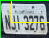

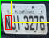

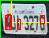

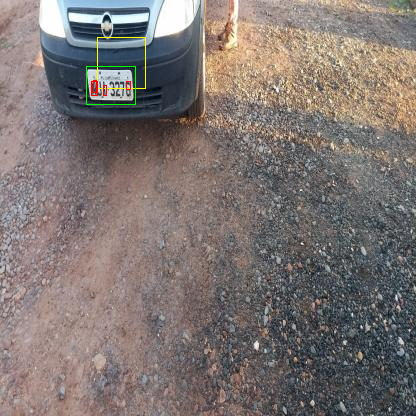

[0.25495756 0.0783191  0.3760892  0.18448421]


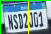

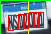

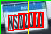

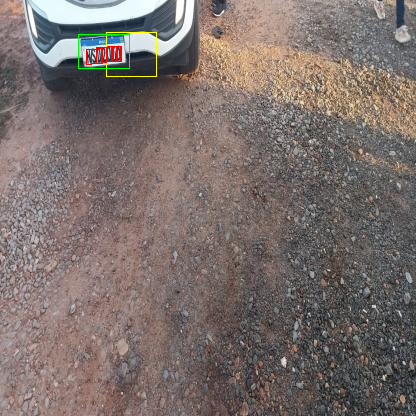

[0.23160422 0.06780058 0.34456545 0.18901214]


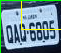

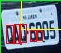

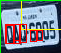

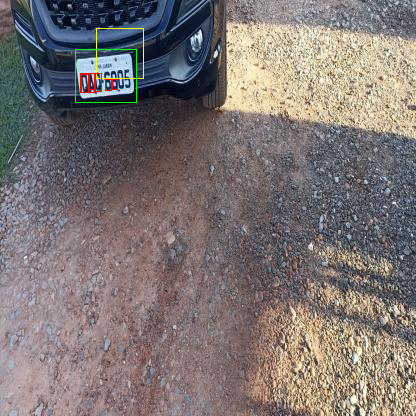

[0.36597687 0.15813267 0.49420643 0.391772  ]


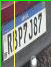

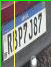

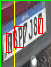

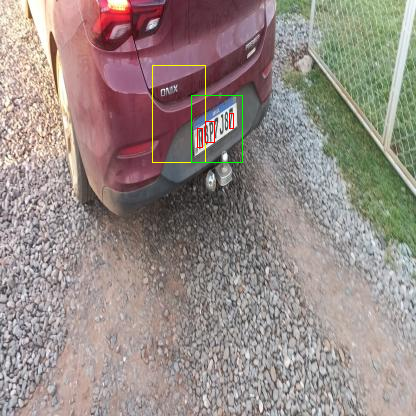

[0.28202564 0.09601328 0.364066   0.23352504]


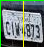

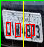

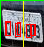

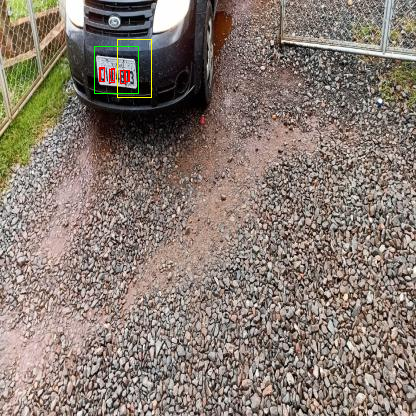

In [158]:
from tensorflow.keras.preprocessing.image import img_to_array

csv = FileCsv()
improc = Image()
dicionarioImagens = csv.read('test/_annotations.csv')


for key in dicionarioImagens.keys():
  img = cv2.imread( os.path.join('test',key) )
  imgNovo = cv2.resize(img, (TAMANHO_IMAGEM,TAMANHO_IMAGEM), interpolation= cv2.INTER_LINEAR)
  imgArray = img_to_array(imgNovo)/255.0
  imgArray = np.expand_dims(imgArray, axis=0)
  preds = model.predict(imgArray)[0]
  print(preds)
  (H,W) = img.shape[:2]

  point = [int(preds[0]*W) , int(preds[1]*H) , int(preds[2]*W), int(preds[3]*H) ] # Restaura a normalização
  
  img = ld.drawPlate(img, point, color=(0,255,255))        # Essas são as imagens preditas pela rede
  img = ld.drawPlate(img, dicionarioImagens.get(key)[0])   # Essas são as imagens anotadas manualmente

  cv2_imshow(ld.getRoi(img, dicionarioImagens.get(key)[0]))
  improc.processing(ld.getRoi(img, dicionarioImagens.get(key)[0]))

  cv2_imshow(img)
